In [1]:
import os
import numpy as np
import tensorflow as tf

from keras import Model
from keras.utils import image_dataset_from_directory, get_file
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Flatten, Dense, Dropout

os.chdir("/tf/notebooks")   # Required to change dir in docker container to see local modules

from dataCleaning import load_and_preprocess_img

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2023-04-29 09:45:16.526289: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.12.0
Num GPUs Available:  1


2023-04-29 09:45:17.646463: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-29 09:45:17.649418: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-29 09:45:17.649551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
def init_vgg16():
    vgg16 = VGG16(weights=None,
                  include_top=False,
                  input_shape=(224, 224, 3))

    # Create a new 'top' of the model of fully-connected layers for Places365
    top_model = vgg16.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu', name="fc1")(top_model)
    top_model = Dropout(0.5, name="drop_fc1")(top_model)
    top_model = Dense(4096, activation='relu', name="fc2")(top_model)
    top_model = Dropout(0.2, name="drop_fc2")(top_model)
    output_layer = Dense(365, activation='softmax', name="predictions")(top_model)

    model = Model(inputs=vgg16.input,
                  outputs=output_layer,
                  name="vgg16-places365")

    WEIGHTS_PATH = 'https://github.com/GKalliatakis/Keras-VGG16-places365/releases/download/v1.0/vgg16-places365_weights_tf_dim_ordering_tf_kernels.h5'

    weights_path = get_file('vgg16-places365_weights_tf_dim_ordering_tf_kernels.h5',
                        WEIGHTS_PATH,
                        cache_subdir='models')

    model.load_weights(weights_path)

    return model

In [3]:
model = init_vgg16()
model.summary()

2023-04-29 09:45:17.667203: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-29 09:45:17.667352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-29 09:45:17.667460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

543085444/543085444 [==============================] - 47s 0us/step
Model: "vgg16-places365"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                 

In [12]:
def preprocess_labelled_image(image: tf.Tensor, label) -> tuple:
    return tf.divide(image, 255), label


def load_data(filepath: str) -> tf.data.Dataset:
    dataset = image_dataset_from_directory(filepath,
                                        # labels='inferred',
                                        # label_mode='binary',
                                        color_mode='rgb',
                                        image_size=(224,224))
    # dataset = dataset.map(preprocess_labelled_image)
    return dataset

data = load_data("/tf/notebooks/data/classification")

Found 6767 files belonging to 2 classes.


2023-04-29 09:56:47.598471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6767]
	 [[{{node Placeholder/_4}}]]
2023-04-29 09:56:47.598822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6767]
	 [[{{node Placeholder/_4}}]]


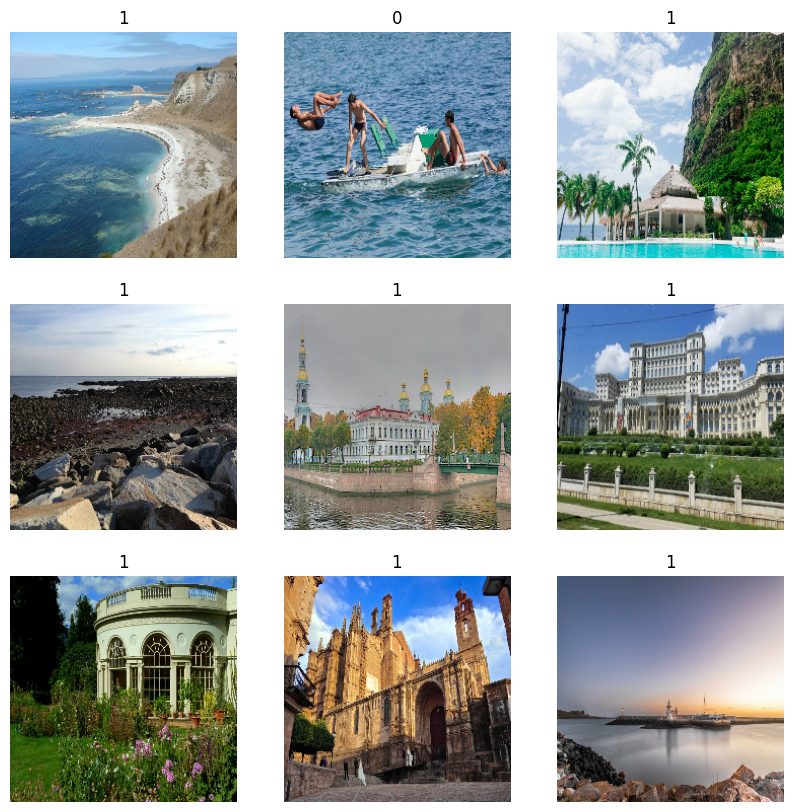

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"{labels[i]}")
    plt.axis("off")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)


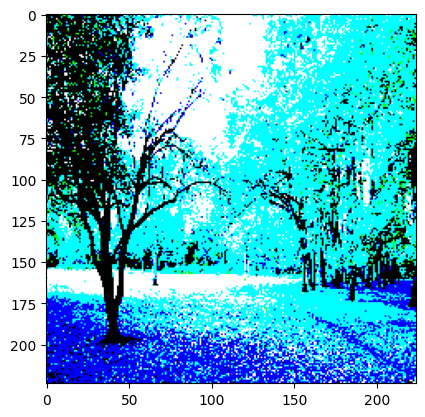

In [8]:
img = load_and_preprocess_img('data/test_img.jpg')
img = np.expand_dims(img, 0)
print(img.shape)
plt.imshow(img[0])


In [13]:
preds = model.predict(data.take(1))

2023-04-29 08:44:32.462459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6767]
	 [[{{node Placeholder/_0}}]]
2023-04-29 08:44:32.462795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6767]
	 [[{{node Placeholder/_4}}]]


ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "vgg16-places365" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 256, 256, 3)


In [7]:
no_of_predictions = 5
top_preds = np.argsort(preds)[::-1][0:no_of_predictions]

In [8]:
import os

# load the class label
file_name = 'categories_places365.txt'
if not os.access(file_name, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    os.system('wget ' + synset_url)
classes = list()
with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
classes = tuple(classes)

In [ ]:
type(top_preds)

In [ ]:
print('--PREDICTED SCENE CATEGORIES:')
# output the prediction
for i in range(0, no_of_predictions):
    print(classes[top_preds[i]])

In [ ]:
def get_prediction_labels(predictions: np.ndarray) -> list:
    l = []
    for i in range(len(predictions)):
        l.append(classes[predictions[i]])

    return l

In [ ]:
get_prediction_labels(top_preds)